In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import FashionMNIST

from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import os
import imageio
import re
from IPython.display import Image, display
from tqdm import tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out,
                              kernel_size=(3, 3), stride=stride)
        self.bn = nn.BatchNorm2d(ch_out)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [7]:
class NeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        layer_config = ((64, 2), (64, 1), (128, 2), (128, 1))

        ch_in = 1
        ch_bottleneck = 2
        block_list = []
        for ch_out, stride in layer_config:
            block = ConvBlock(ch_in, ch_out, stride)
            block_list.append(block)
            ch_in = ch_out

        self.backbone = nn.Sequential(*block_list)

        self.information_bottleneck = nn.Linear(layer_config[-1][0], ch_bottleneck)
        self.head = nn.Linear(ch_bottleneck, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, input):
        featuremap = self.backbone(input)
        squashed = F.adaptive_avg_pool2d(featuremap, output_size=(1, 1))
        squeezed = squashed.view(squashed.shape[0], -1)
        self.bottleneck_out = self.information_bottleneck(squeezed)
        pred = self.head(self.bottleneck_out)

        self.softmax_vals = self.softmax(pred)
        return pred

    @classmethod
    def loss(cls, pred, gt):
        return F.cross_entropy(pred, gt)

In [33]:
class Trainer:
    def __init__(self):

        self.train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.7, 1.1)),
            transforms.ToTensor(),
        ])
        self.val_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        train_dataset = FashionMNIST("./data", train=True,
                                     transform=self.train_transform,
                                     download=True)
        self.val_dataset = FashionMNIST("./data", train=False,
                                   transform=self.val_transform,
                                   download=True)

        batch_size = 1024
        self.train_loader = data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=4)
        self.val_loader = data.DataLoader(self.val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.net = NeuralNet()
        self.net.to(self.device)

        self.logger = SummaryWriter()
        self.i_batch = 0
        self.images = []

    def train(self):

        num_epochs = 200

        optimizer = torch.optim.AdamW(self.net.parameters(), lr=1e-3)

        for i_epoch in tqdm(range(num_epochs)):
            self.net.train()
            self.i_epoch = i_epoch

            for feature_batch, gt_batch in self.train_loader:
                feature_batch = feature_batch.to(self.device)
                gt_batch = gt_batch.to(self.device)

                pred_batch = self.net(feature_batch)

                loss = NeuralNet.loss(pred_batch, gt_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.logger.add_scalar("train/loss", loss.item(), self.i_batch)

                if self.i_batch % 100 == 0:
                    print(f"batch={self.i_batch} loss={loss.item():.6f}")

                self.i_batch += 1

            self.validate()

            torch.save(self.net, "model.pth")

    def validate(self):
        self.net.eval()

        loss_all = []
        pred_all = []
        gt_all = []

        x = []
        y = []
        colormap = ["black", "green", "red", "purple", "blue", "yellow", "orange", "pink", "grey", "brown"]
        plt.figure(figsize=(12, 10), dpi=80)
        plt.grid()
        plt.xlim(-50, 50)
        plt.ylim(-50, 50)

        self.validataion_samples = defaultdict(list)
        for index, sample in enumerate(self.val_dataset):
            class_index = sample[1]
            if len(self.validataion_samples[class_index]) < 10 :
                self.validataion_samples[class_index].append(self.val_dataset[index])

        for key, value in self.validataion_samples.items():
            stacked_samples = [value[i][0][None, :, :, :] for i in range(len(value))]
            feature_batch = torch.cat(stacked_samples, 0).to(self.device)
            pred = self.net(feature_batch).to(self.device)

            x = self.net.bottleneck_out[:, 0].cpu().detach().numpy() 
            y = self.net.bottleneck_out[:, 1].cpu().detach().numpy()

            plt.scatter(x, y, c=colormap[key])
        
        image = f"epoch_{self.i_epoch}.png"
        plt.savefig(f"images/bottleneck/{image}")
        plt.close()

        self.images.append(image)

        for feature_batch, gt_batch in self.val_loader:
            feature_batch = feature_batch.to(self.device)
            gt_batch = gt_batch.to(self.device)

            with torch.no_grad():
                pred_batch = self.net(feature_batch)
                loss = NeuralNet.loss(pred_batch, gt_batch)

            loss_all.append(loss.item())
            pred_all.append(pred_batch.cpu().numpy())
            gt_all.append(gt_batch.cpu().numpy())

        loss_mean = np.mean(np.array(loss_all))
        pred_all = np.argmax(np.concatenate(pred_all, axis=0), axis=1)
        gt_all = np.concatenate(np.array(gt_all))

        accuracy = np.sum(np.equal(pred_all, gt_all)) / len(pred_all)

        self.logger.add_scalar("val/loss", loss_mean, self.i_batch)
        self.logger.add_scalar("val/accuracy", accuracy, self.i_batch)

        print(f"Val_loss={loss_mean} val_accu={accuracy:.6f}")

In [32]:
def main():
    trainer = Trainer()
    trainer.train()

    # net = NeuralNet()
    # trainer.net = torch.load("model.pth")

    gif = []

    for image in trainer.images: 
        imagetogif = imageio.v2.imread(f"./images/bottleneck/{image}")
        gif.append(imagetogif)

    imageio.mimsave('gif_bottleneck.gif', gif, duration = 1)
    display(Image(open('gif_bottleneck.gif','rb').read()))
      
    from IPython.core.interactiveshell import InteractiveShell
    InteractiveShell.ast_node_interactivity = "all"

    print("Done!")

  0%|                                                   | 0/100 [00:00<?, ?it/s]

batch=0 loss=2.387387


/tmp/ipykernel_10623/2180622192.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gt_all = np.concatenate(np.array(gt_all))
  1%|▍                                          | 1/100 [00:04<07:28,  4.53s/it]

Val_loss=1.6090296506881714 val_accu=0.448100
batch=100 loss=1.439549


  2%|▊                                          | 2/100 [00:09<07:28,  4.57s/it]

Val_loss=1.3404461026191712 val_accu=0.529500


  3%|█▎                                         | 3/100 [00:13<07:21,  4.55s/it]

Val_loss=1.1645193815231323 val_accu=0.577300
batch=200 loss=1.120145


  4%|█▋                                         | 4/100 [00:18<07:20,  4.59s/it]

Val_loss=1.0392349004745483 val_accu=0.664000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1c28f061f0>
Traceback (most recent call last):
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1c28f061f0>
Traceback (most recent call last):
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_ali

Val_loss=0.9561782062053681 val_accu=0.684200


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1c28f061f0>
Traceback (most recent call last):
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1c28f061f0>
Traceback (most recent call last):
  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/home/ivan/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
Exception ignored in: AssertionError    <function _MultiProce

batch=300 loss=0.936742


  6%|██▌                                        | 6/100 [00:28<07:50,  5.01s/it]

Val_loss=0.9052544176578522 val_accu=0.694800
batch=400 loss=0.826983


  7%|███                                        | 7/100 [00:33<07:36,  4.91s/it]

Val_loss=0.8457567453384399 val_accu=0.682400


  8%|███▍                                       | 8/100 [00:38<07:26,  4.86s/it]

Val_loss=0.7804524064064026 val_accu=0.717500
batch=500 loss=0.779175


  9%|███▊                                       | 9/100 [00:42<07:11,  4.74s/it]

Val_loss=0.7049515426158905 val_accu=0.727300


 10%|████▏                                     | 10/100 [00:47<07:03,  4.70s/it]

Val_loss=0.6593023478984833 val_accu=0.746800
batch=600 loss=0.672320


 11%|████▌                                     | 11/100 [00:52<06:59,  4.72s/it]

Val_loss=0.6715267717838287 val_accu=0.749700
batch=700 loss=0.590585


 12%|█████                                     | 12/100 [00:56<06:52,  4.69s/it]

Val_loss=0.6249440133571624 val_accu=0.762000


 13%|█████▍                                    | 13/100 [01:01<06:45,  4.67s/it]

Val_loss=0.6484505891799927 val_accu=0.772400
batch=800 loss=0.603070


 14%|█████▉                                    | 14/100 [01:06<06:38,  4.64s/it]

Val_loss=0.6006577253341675 val_accu=0.811100


 15%|██████▎                                   | 15/100 [01:10<06:35,  4.65s/it]

Val_loss=0.5786894798278809 val_accu=0.829200
batch=900 loss=0.581877


 16%|██████▋                                   | 16/100 [01:15<06:27,  4.62s/it]

Val_loss=0.5506547451019287 val_accu=0.841700
batch=1000 loss=0.548921


 17%|███████▏                                  | 17/100 [01:19<06:20,  4.58s/it]

Val_loss=0.5488083481788635 val_accu=0.840100


 18%|███████▌                                  | 18/100 [01:24<06:16,  4.59s/it]

Val_loss=0.561037290096283 val_accu=0.835400
batch=1100 loss=0.565431


 19%|███████▉                                  | 19/100 [01:29<06:14,  4.62s/it]

Val_loss=0.5668745458126068 val_accu=0.827300


 20%|████████▍                                 | 20/100 [01:33<06:12,  4.66s/it]

Val_loss=0.5630429923534394 val_accu=0.829700
batch=1200 loss=0.522835


 21%|████████▊                                 | 21/100 [01:38<06:07,  4.66s/it]

Val_loss=0.5189099460840225 val_accu=0.845800


 22%|█████████▏                                | 22/100 [01:43<06:03,  4.65s/it]

Val_loss=0.5088105231523514 val_accu=0.848900
batch=1300 loss=0.570887


 23%|█████████▋                                | 23/100 [01:47<05:59,  4.66s/it]

Val_loss=0.5083801716566085 val_accu=0.848800
batch=1400 loss=0.472888


 24%|██████████                                | 24/100 [01:52<05:53,  4.65s/it]

Val_loss=0.48112377524375916 val_accu=0.853600


 25%|██████████▌                               | 25/100 [01:57<05:52,  4.69s/it]

Val_loss=0.5010417193174362 val_accu=0.845800
batch=1500 loss=0.472014


 26%|██████████▉                               | 26/100 [02:02<05:48,  4.72s/it]

Val_loss=0.48383077085018156 val_accu=0.851400


 27%|███████████▎                              | 27/100 [02:06<05:48,  4.77s/it]

Val_loss=0.4852012306451797 val_accu=0.852300
batch=1600 loss=0.473794


 28%|███████████▊                              | 28/100 [02:11<05:42,  4.75s/it]

Val_loss=0.46773015558719633 val_accu=0.856600
batch=1700 loss=0.462174


 29%|████████████▏                             | 29/100 [02:16<05:45,  4.86s/it]

Val_loss=0.4717997252941132 val_accu=0.862100


 30%|████████████▌                             | 30/100 [02:22<05:49,  4.99s/it]

Val_loss=0.45028606951236727 val_accu=0.866400
batch=1800 loss=0.467243


 31%|█████████████                             | 31/100 [02:26<05:39,  4.92s/it]

Val_loss=0.44295509457588195 val_accu=0.868800


 32%|█████████████▍                            | 32/100 [02:31<05:32,  4.89s/it]

Val_loss=0.5101978123188019 val_accu=0.841600
batch=1900 loss=0.489063


 33%|█████████████▊                            | 33/100 [02:36<05:24,  4.84s/it]

Val_loss=0.44167140424251555 val_accu=0.868600
batch=2000 loss=0.370460


 34%|██████████████▎                           | 34/100 [02:41<05:17,  4.81s/it]

Val_loss=0.47035532891750337 val_accu=0.854600


 35%|██████████████▋                           | 35/100 [02:45<05:11,  4.79s/it]

Val_loss=0.4588279128074646 val_accu=0.857000
batch=2100 loss=0.401740


 36%|███████████████                           | 36/100 [02:50<05:05,  4.78s/it]

Val_loss=0.49064952731132505 val_accu=0.850900


 37%|███████████████▌                          | 37/100 [02:55<04:58,  4.74s/it]

Val_loss=0.46122564673423766 val_accu=0.855900
batch=2200 loss=0.531353


 38%|███████████████▉                          | 38/100 [02:59<04:53,  4.74s/it]

Val_loss=0.4768394947052002 val_accu=0.855600
batch=2300 loss=0.433353


 39%|████████████████▍                         | 39/100 [03:04<04:47,  4.71s/it]

Val_loss=0.4811573147773743 val_accu=0.854100


 40%|████████████████▊                         | 40/100 [03:09<04:42,  4.71s/it]

Val_loss=0.45985127091407774 val_accu=0.860100
batch=2400 loss=0.401418


 41%|█████████████████▏                        | 41/100 [03:14<04:38,  4.72s/it]

Val_loss=0.43711844384670256 val_accu=0.864000


 42%|█████████████████▋                        | 42/100 [03:18<04:33,  4.71s/it]

Val_loss=0.43862316608428953 val_accu=0.868400
batch=2500 loss=0.463311


 43%|██████████████████                        | 43/100 [03:23<04:29,  4.72s/it]

Val_loss=0.4402079701423645 val_accu=0.866300


 44%|██████████████████▍                       | 44/100 [03:28<04:23,  4.70s/it]

Val_loss=0.4200832396745682 val_accu=0.872700
batch=2600 loss=0.380264


 45%|██████████████████▉                       | 45/100 [03:32<04:16,  4.67s/it]

Val_loss=0.4262891560792923 val_accu=0.869800
batch=2700 loss=0.396530


 46%|███████████████████▎                      | 46/100 [03:37<04:13,  4.69s/it]

Val_loss=0.4178087741136551 val_accu=0.871400


 47%|███████████████████▋                      | 47/100 [03:42<04:07,  4.68s/it]

Val_loss=0.4094302713871002 val_accu=0.876700
batch=2800 loss=0.413618


 48%|████████████████████▏                     | 48/100 [03:46<04:02,  4.67s/it]

Val_loss=0.42080630362033844 val_accu=0.874200


 49%|████████████████████▌                     | 49/100 [03:51<03:58,  4.67s/it]

Val_loss=0.48886739611625674 val_accu=0.853000
batch=2900 loss=0.436744


 50%|█████████████████████                     | 50/100 [03:56<03:54,  4.69s/it]

Val_loss=0.4224241554737091 val_accu=0.866300
batch=3000 loss=0.419368


 51%|█████████████████████▍                    | 51/100 [04:00<03:49,  4.67s/it]

Val_loss=0.42871389985084535 val_accu=0.870700


 52%|█████████████████████▊                    | 52/100 [04:05<03:43,  4.67s/it]

Val_loss=0.42278011441230773 val_accu=0.870400
batch=3100 loss=0.399918


 53%|██████████████████████▎                   | 53/100 [04:10<03:39,  4.67s/it]

Val_loss=0.41103863418102266 val_accu=0.875600


 54%|██████████████████████▋                   | 54/100 [04:14<03:34,  4.66s/it]

Val_loss=0.40625027716159823 val_accu=0.879100
batch=3200 loss=0.393208


 55%|███████████████████████                   | 55/100 [04:19<03:29,  4.66s/it]

Val_loss=0.404401907324791 val_accu=0.879100
batch=3300 loss=0.433405


 56%|███████████████████████▌                  | 56/100 [04:24<03:26,  4.68s/it]

Val_loss=0.4193926930427551 val_accu=0.869200


 57%|███████████████████████▉                  | 57/100 [04:28<03:21,  4.69s/it]

Val_loss=0.4344414234161377 val_accu=0.868100
batch=3400 loss=0.367453


 58%|████████████████████████▎                 | 58/100 [04:33<03:17,  4.70s/it]

Val_loss=0.40356360375881195 val_accu=0.878100


 59%|████████████████████████▊                 | 59/100 [04:38<03:20,  4.88s/it]

Val_loss=0.4008627951145172 val_accu=0.880200
batch=3500 loss=0.367172


 60%|█████████████████████████▏                | 60/100 [04:44<03:20,  5.01s/it]

Val_loss=0.43851043581962584 val_accu=0.870200


 61%|█████████████████████████▌                | 61/100 [04:48<03:11,  4.91s/it]

Val_loss=0.4061193734407425 val_accu=0.876200
batch=3600 loss=0.386847


 62%|██████████████████████████                | 62/100 [04:53<03:03,  4.84s/it]

Val_loss=0.39004736244678495 val_accu=0.883700
batch=3700 loss=0.368416


 63%|██████████████████████████▍               | 63/100 [04:58<02:58,  4.81s/it]

Val_loss=0.40867368280887606 val_accu=0.877000


 64%|██████████████████████████▉               | 64/100 [05:03<02:52,  4.78s/it]

Val_loss=0.4366057127714157 val_accu=0.871700
batch=3800 loss=0.363729


 65%|███████████████████████████▎              | 65/100 [05:07<02:46,  4.76s/it]

Val_loss=0.39865138530731203 val_accu=0.881300


 66%|███████████████████████████▋              | 66/100 [05:12<02:40,  4.73s/it]

Val_loss=0.3941724896430969 val_accu=0.884800
batch=3900 loss=0.331637


 67%|████████████████████████████▏             | 67/100 [05:17<02:36,  4.74s/it]

Val_loss=0.4039049863815308 val_accu=0.879600
batch=4000 loss=0.354392


 68%|████████████████████████████▌             | 68/100 [05:22<02:33,  4.79s/it]

Val_loss=0.40037032663822175 val_accu=0.880600


 69%|████████████████████████████▉             | 69/100 [05:26<02:28,  4.80s/it]

Val_loss=0.4606348693370819 val_accu=0.860800
batch=4100 loss=0.367263


 70%|█████████████████████████████▍            | 70/100 [05:31<02:22,  4.75s/it]

Val_loss=0.4047003448009491 val_accu=0.881000


 71%|█████████████████████████████▊            | 71/100 [05:36<02:17,  4.74s/it]

Val_loss=0.41972682178020476 val_accu=0.875600
batch=4200 loss=0.323458


 72%|██████████████████████████████▏           | 72/100 [05:40<02:12,  4.74s/it]

Val_loss=0.42138486802577974 val_accu=0.871000
batch=4300 loss=0.359075


 73%|██████████████████████████████▋           | 73/100 [05:45<02:07,  4.74s/it]

Val_loss=0.40263689756393434 val_accu=0.874900


 74%|███████████████████████████████           | 74/100 [05:50<02:03,  4.75s/it]

Val_loss=0.3914161592721939 val_accu=0.887800
batch=4400 loss=0.351165


 75%|███████████████████████████████▌          | 75/100 [05:55<01:57,  4.72s/it]

Val_loss=0.38581560254096986 val_accu=0.888500


 76%|███████████████████████████████▉          | 76/100 [05:59<01:53,  4.72s/it]

Val_loss=0.3885249584913254 val_accu=0.886200
batch=4500 loss=0.346513


 77%|████████████████████████████████▎         | 77/100 [06:04<01:48,  4.72s/it]

Val_loss=0.38101400434970856 val_accu=0.888700
batch=4600 loss=0.370582


 78%|████████████████████████████████▊         | 78/100 [06:09<01:44,  4.74s/it]

Val_loss=0.4033801883459091 val_accu=0.882400


 79%|█████████████████████████████████▏        | 79/100 [06:14<01:39,  4.74s/it]

Val_loss=0.38198086619377136 val_accu=0.883800
batch=4700 loss=0.318986


 80%|█████████████████████████████████▌        | 80/100 [06:18<01:35,  4.75s/it]

Val_loss=0.37884378135204316 val_accu=0.887600


 81%|██████████████████████████████████        | 81/100 [06:23<01:30,  4.79s/it]

Val_loss=0.40838544368743895 val_accu=0.880800
batch=4800 loss=0.314220


 82%|██████████████████████████████████▍       | 82/100 [06:28<01:26,  4.79s/it]

Val_loss=0.3717119961977005 val_accu=0.892700


 83%|██████████████████████████████████▊       | 83/100 [06:33<01:20,  4.76s/it]

Val_loss=0.3994578093290329 val_accu=0.883300
batch=4900 loss=0.352649


 84%|███████████████████████████████████▎      | 84/100 [06:37<01:15,  4.73s/it]

Val_loss=0.38322775065898895 val_accu=0.885100
batch=5000 loss=0.333986


 85%|███████████████████████████████████▋      | 85/100 [06:42<01:11,  4.77s/it]

Val_loss=0.37175686061382296 val_accu=0.891000


 86%|████████████████████████████████████      | 86/100 [06:47<01:06,  4.76s/it]

Val_loss=0.3965973049402237 val_accu=0.885900
batch=5100 loss=0.301011


 87%|████████████████████████████████████▌     | 87/100 [06:52<01:02,  4.80s/it]

Val_loss=0.4176026344299316 val_accu=0.878000


 88%|████████████████████████████████████▉     | 88/100 [06:57<00:57,  4.76s/it]

Val_loss=0.36506848931312563 val_accu=0.896700
batch=5200 loss=0.336006


 89%|█████████████████████████████████████▍    | 89/100 [07:01<00:52,  4.78s/it]

Val_loss=0.4166351854801178 val_accu=0.883000
batch=5300 loss=0.356211


 90%|█████████████████████████████████████▊    | 90/100 [07:06<00:47,  4.78s/it]

Val_loss=0.38844390511512755 val_accu=0.883700


 91%|██████████████████████████████████████▏   | 91/100 [07:11<00:43,  4.78s/it]

Val_loss=0.4158138960599899 val_accu=0.881500
batch=5400 loss=0.310691


 92%|██████████████████████████████████████▋   | 92/100 [07:16<00:37,  4.74s/it]

Val_loss=0.3723094195127487 val_accu=0.892800


 93%|███████████████████████████████████████   | 93/100 [07:20<00:33,  4.75s/it]

Val_loss=0.3809124916791916 val_accu=0.892000
batch=5500 loss=0.358443


 94%|███████████████████████████████████████▍  | 94/100 [07:26<00:29,  4.94s/it]

Val_loss=0.378670859336853 val_accu=0.893200
batch=5600 loss=0.312081


 95%|███████████████████████████████████████▉  | 95/100 [07:31<00:25,  5.10s/it]

Val_loss=0.382598078250885 val_accu=0.888400


 96%|████████████████████████████████████████▎ | 96/100 [07:36<00:19,  5.00s/it]

Val_loss=0.3636603683233261 val_accu=0.890200
batch=5700 loss=0.329869


 97%|████████████████████████████████████████▋ | 97/100 [07:41<00:14,  4.92s/it]

Val_loss=0.3880248874425888 val_accu=0.883000


 98%|█████████████████████████████████████████▏| 98/100 [07:45<00:09,  4.84s/it]

Val_loss=0.3821395426988602 val_accu=0.891400
batch=5800 loss=0.325510


 99%|█████████████████████████████████████████▌| 99/100 [07:50<00:04,  4.82s/it]

Val_loss=0.3724096864461899 val_accu=0.893100


100%|█████████████████████████████████████████| 100/100 [07:55<00:00,  4.75s/it]

Val_loss=0.39554813504219055 val_accu=0.889100


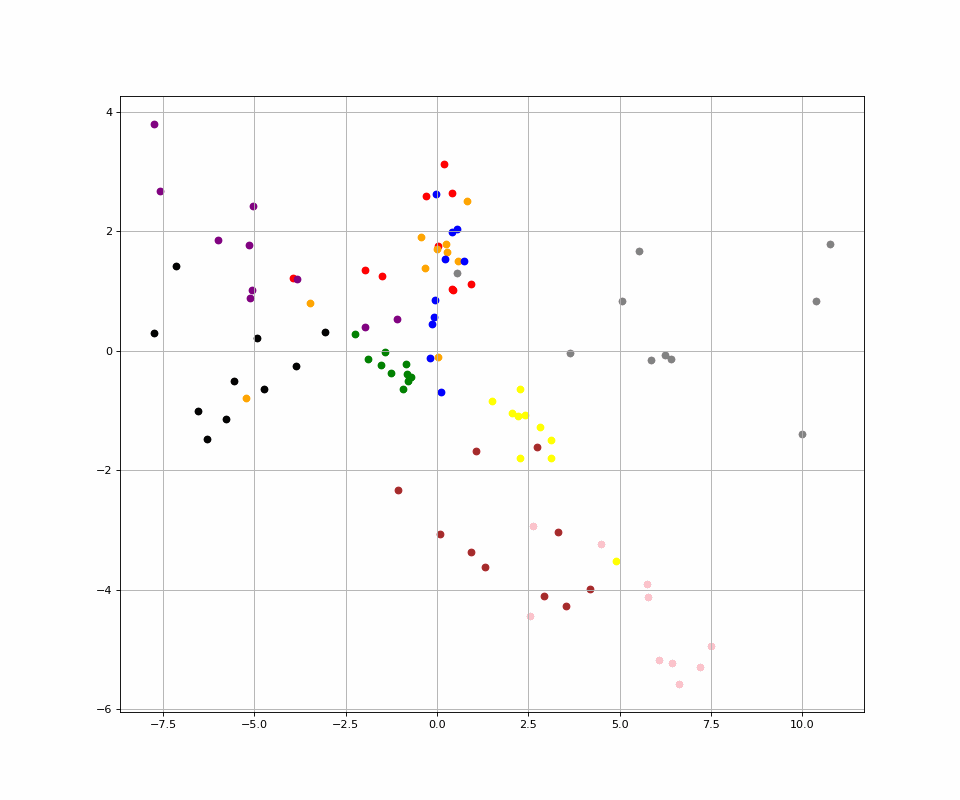

Done!


In [34]:
if __name__ == "__main__":
    main()